# 08_Simple-MLP-unsupervised

Extend the original simple MLP pruning model but change the output task to a self-supervised task.

Clustering like in DrLIM with contrastive loss (Hadsell et. al. 2005)
- The goal was to make a better clustering algorithm
- Use prior knowledge put similar points together vs others
- Trained a siamese network: same network applied on two different data points. Then take the distance of resulting embeddings. Use this distance to calculate the loss.

- They used a CNN. Any idea if this can work on an MLP?

In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
! python scripts/simple_mlp_unsupervised_train.py

Traceback (most recent call last):
  File "/home/clc926/Desktop/klab_rotation/scripts/simple_mlp_unsupervised_train.py", line 1, in <module>
    from ..src.simple_pruning_growth_model import DrLIMPruneGrowNetwork, ContrastiveLoss, constrative_test_loop
ImportError: attempted relative import with no known parent package


In [2]:
from src.simple_pruning_growth_model import DrLIMPruneGrowNetwork, ContrastiveLoss, constrative_test_loop
from src.training_testing_loop import full_train, save_model_attr, format_training_outputs
from src.load_MNIST import get_mnist_pairs_loader
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn

For now, directly use the labels to make the pairs. Next, implement pairs that is label agnostic via simple eucledian distance and creating a neighborhood graph

In [12]:
train_pair_dataloader, val_pair_dataloader = get_mnist_pairs_loader(
    batch_size=32, train=True, subset_fraction=0.05, validation_ratio=6, seed=42, 
    selected_labels=[4, 9]
)

In [8]:
np.unique(train_pair_dataloader.dataset.dataset.pair_labels, return_counts=True)

(array([0., 1.], dtype=float32), array([1199, 1159]))

In [13]:
test_pair_dataloader = get_mnist_pairs_loader(batch_size=32, train=False, subset_fraction=0.05,  selected_labels=[4, 9])

In [14]:
len(test_pair_dataloader.dataset)

198

Using Tanh activation for the prediction head to see if this help constrain the gradients. Tanh constrains the output to be between -1 and 1.

No Pruning, linear prediction activation

In [16]:
DrLIM_model = DrLIMPruneGrowNetwork(
    gamma=0.1, init_density=0.5, num_training_iter=100,
    low_mapping_dim=2, prediction_act=lambda x: x, use_grow_prune_prob=False
)

contrastive_loss_fn = ContrastiveLoss(m=0.2) # if I am using tanh, range is between -1 and 1.
val_contrastive_loss_fn = ContrastiveLoss(m=0.2, reduction='sum')

train_losses_epoch, val_losses_epoch, test_df, model_state_dicts = full_train(
    DrLIM_model, train_pair_dataloader, val_pair_dataloader, test_pair_dataloader,
    learning_rate = 1e-3, 
    loss_fn=contrastive_loss_fn,
    val_loss_fn=val_contrastive_loss_fn,
    plot=False, verbose=False,
    test_loop_func=constrative_test_loop,
    margin=contrastive_loss_fn.m,
    args_expand=True,
)

Epochs: 100%|██████████| 100/100 [04:55<00:00,  2.95s/it]


In [28]:
stack_training_losses_df, stack_val_losses_df = format_training_outputs(train_losses_epoch, val_losses_epoch)

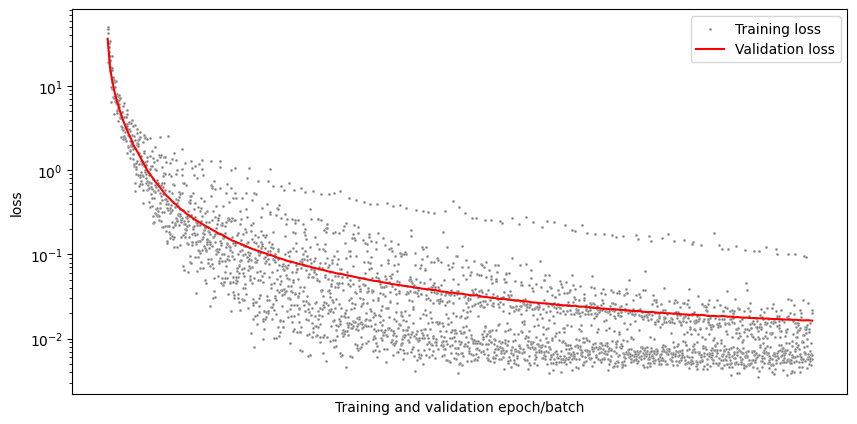

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(stack_training_losses_df.reset_index(), x='index', y='loss', label='Training loss', alpha=1.0, c='gray', s=4, ax=ax)
sns.lineplot(stack_val_losses_df.reset_index(), x='index', y='loss',  label='Validation loss', c='red', ax=ax)
plt.xticks([])
plt.xlabel('Training and validation epoch/batch')
plt.yscale('log')
plt.show()

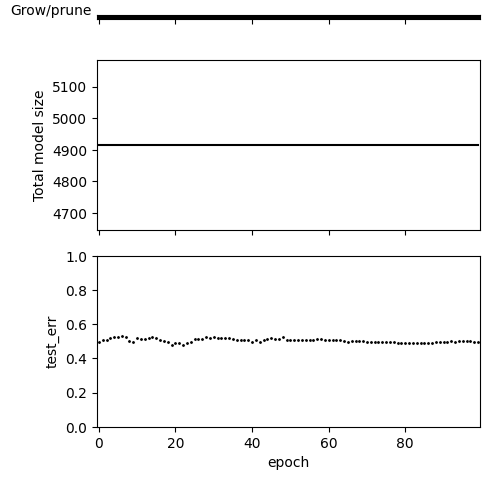

In [30]:
fig, axes = plt.subplots(3, 1, figsize=(5, 5), sharex=True, height_ratios=[1, 5, 5])
axes[0].imshow(np.array(np.array(DrLIM_model.grow_prune_history).reshape(1, -1)), cmap='gray')
axes[0].set_yticks([])
axes[0].set_ylabel("Grow/prune", rotation=0, ha='right')

axes[1].plot(DrLIM_model.synapse_count_history, c='k') 
axes[1].set_ylabel("Total model size")

sns.scatterplot(test_df.reset_index(), x='epoch', y='test_err', ax=axes[2], c='k', s=5) 
axes[2].set_ylim(0, 1.0)
plt.tight_layout()
plt.show()


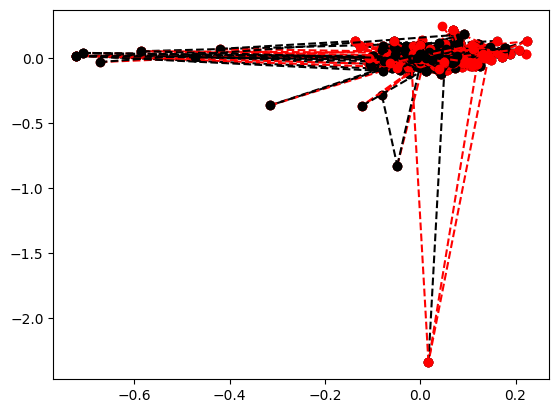

In [31]:
DrLIM_model.eval()
colors = {1: 'ro--', 0: 'ko--'}
with torch.no_grad():
    for X, y in train_pair_dataloader:
        pred = DrLIM_model(X)
        for i in range(len(pred[0])):
            plt.plot([pred[0][i, 0], pred[1][i, 0]], [pred[0][i, 1], pred[1][i, 1]], colors[y[i].item()])
    plt.show()

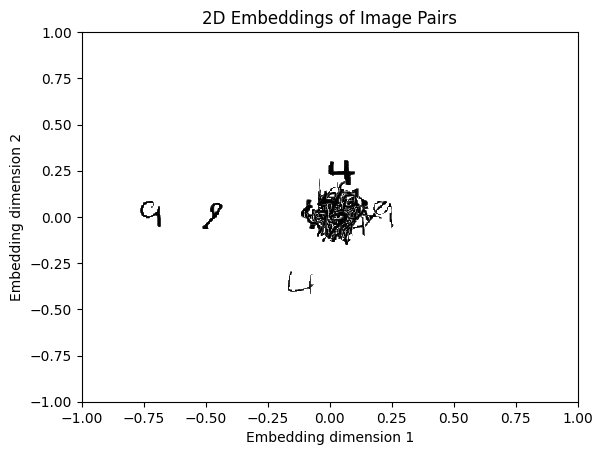

In [32]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

DrLIM_model.eval()
colors = {1: 'red', 0: 'black'}  # Solid colors for points
line_styles = {1: 'r--', 0: 'k--'}  # Dashed lines for connections
fig, ax = plt.subplots()

ax.set_xlabel('Embedding dimension 1')
ax.set_ylabel('Embedding dimension 2')
ax.set_title('2D Embeddings of Image Pairs')
ax.set_ylim(-1, 1)
ax.set_xlim(-1, 1)

def plot_img_embedding(img, x, y):
    img[img < -0.1] = np.nan
    im = OffsetImage(img, cmap='gray_r', zoom=1.0)
    return AnnotationBbox(im, (x, y), xycoords='data', frameon=False)

with torch.no_grad():
    artists = []
    for X, y in train_pair_dataloader:
        pred = DrLIM_model(X)

        for i in range(len(pred[0])):
            # Plot points for both images in the pair
            # plt.scatter(pred[0][i, 0], pred[0][i, 1], c=colors[y[i].item()], alpha=0.6)
            # plt.scatter(pred[1][i, 0], pred[1][i, 1], c=colors[y[i].item()], alpha=0.6)
            
            ab = plot_img_embedding(X[0][i].permute(1, 2, 0).numpy(), pred[0][i, 0].item(), pred[0][i, 1].item())
            ax.add_artist(ab)

            ab = plot_img_embedding(X[1][i].permute(1, 2, 0).numpy(), pred[1][i, 0].item(), pred[1][i, 1].item())
            ax.add_artist(ab)
            
        break
                
    plt.show()


# Test GPU script
! python scripts/simple_mlp_unsupervised_train.py --device cuda


In [1]:
! sbatch 08_simple_mlp_unsupervised_train.sh

Submitted batch job 54109501
